In [116]:
import numpy as np
def griddata(x, y, z, binsize=0.01, retbin=True, retloc=True):
    """
    Place unevenly spaced 2D data on a grid by 2D binning (nearest
    neighbor interpolation).

    Parameters
    ----------
    x : ndarray (1D)
        The idependent data x-axis of the grid.
    y : ndarray (1D)
        The idependent data y-axis of the grid.
    z : ndarray (1D)
        The dependent data in the form z = f(x,y).
    binsize : scalar, optional
        The full width and height of each bin on the grid.  If each
        bin is a cube, then this is the x and y dimension.  This is
        the step in both directions, x and y. Defaults to 0.01.
    retbin : boolean, optional
        Function returns `bins` variable (see below for description)
        if set to True.  Defaults to True.
    retloc : boolean, optional
        Function returns `wherebins` variable (see below for description)
        if set to True.  Defaults to True.

    Returns
    -------
    grid : ndarray (2D)
        The evenly gridded data.  The value of each cell is the median
        value of the contents of the bin.
    bins : ndarray (2D)
        A grid the same shape as `grid`, except the value of each cell
        is the number of points in that bin.  Returns only if
        `retbin` is set to True.
    wherebin : list (2D)
        A 2D list the same shape as `grid` and `bins` where each cell
        contains the indicies of `z` which contain the values stored
        in the particular bin.

    Revisions
    ---------
    2010-07-11  ccampo  Initial version
    """
    # get extrema values.
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # make coordinate arrays.
    xi      = np.arange(xmin, xmax+binsize, binsize)
    yi      = np.arange(ymin, ymax+binsize, binsize)
    xi, yi = np.meshgrid(xi,yi)

    # make the grid.
    grid           = np.zeros(xi.shape, dtype=x.dtype)
    nrow, ncol = grid.shape
    if retbin: bins = np.copy(grid)

    # create list in same shape as grid to store indices
    if retloc:
        wherebin = np.copy(grid)
        wherebin = wherebin.tolist()

    # fill in the grid.
    for row in range(nrow):
        for col in range(ncol):
            xc = xi[row, col]    # x coordinate.
            yc = yi[row, col]    # y coordinate.

            # find the position that xc and yc correspond to.
            posx = np.abs(x - xc)
            posy = np.abs(y - yc)
            ibin = np.logical_and(posx < binsize/2., posy < binsize/2.)
            ind  = np.where(ibin == True)[0]

            # fill the bin.
            bin = z[ibin]
            if retloc: wherebin[row][col] = ind
            if retbin: bins[row, col] = bin.size
            if bin.size != 0:
                binval         = np.median(bin)
                grid[row, col] = binval
            else:
                grid[row, col] = np.nan   # fill empty bins with nans.

    # return the grid
    if retbin:
        if retloc:
            return grid, bins, wherebin
        else:
            return grid, bins
    else:
        if retloc:
            return grid, wherebin
        else:
            return grid

(-1.1, 1.1)

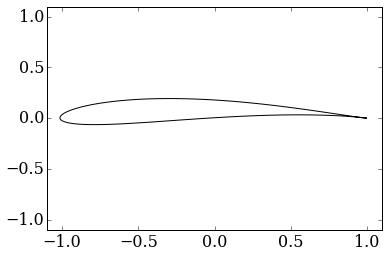

In [117]:
import numpy
from math import pi
from matplotlib import pyplot, mlab
%matplotlib inline
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

def Joukowsky(etha, a):
    z = a/2. * (etha + 1/etha)

    return z

def circulo(centro, R, N):
    alpha = numpy.linspace(0,2*pi,N)

    x_prime = R*numpy.cos(alpha)
    y_prime = R*numpy.sin(alpha)
    
    etha = numpy.array(x_prime+1j*y_prime)
    
    etha += centro
    
    return etha
    
N = 101
R = 1.1
a = 1
centro_x = -0.1
centro_y = 0.
centro = centro_x+centro_y*1j

etha = circulo(centro, R, N)
z = Joukowsky(etha, a)

x = numpy.real(z)
y = numpy.imag(z)

pyplot.figure()
fig=pyplot.plot(x,y,c='k')
pyplot.xlim([-a-0.1,a+0.1])
pyplot.ylim([-a-0.1,a+0.1])

(-3.0, 3.0)

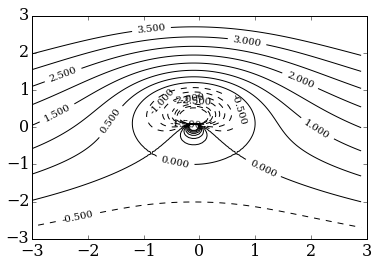

In [118]:
nx = 100
L = 6.0
xp = numpy.linspace(-L/2,L/2,nx)
Xp,Yp = numpy.meshgrid(xp,xp)

r     = numpy.sqrt(Xp**2+Yp**2)
theta = numpy.arctan2(Yp,Xp)

U_inf = 1.
psi_U = U_inf*Yp 

K= R**2*U_inf
psi_d = -K*numpy.sin(theta)/(r)

gamma=10.
psi_v = gamma/(2*pi) * numpy.log(r)

psi_c = psi_U + psi_d + psi_v - gamma/(2*pi)*numpy.log(R)
contours = numpy.arange(-4,4,0.5)

pyplot.figure()
C=pyplot.contour(Xp+centro_x, Yp+centro_y, psi_c, contours, colors='k')
pyplot.clabel(C, inline=1, fontsize=10)

pyplot.xlim([-L/2,L/2])
pyplot.ylim([-L/2,L/2])


(-2, 2)

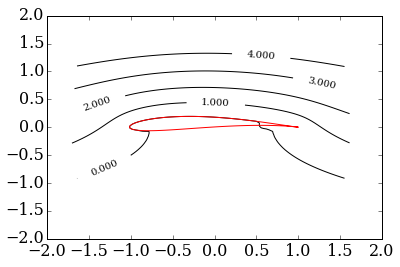

In [119]:
from scipy import interpolate

Zp = (Xp+centro_x) + (Yp+centro_y)*1j
Zp = numpy.array([],dtype=complex)
psi_t = numpy.array([])
for i in range(len(Xp)):
    for j in range(len(Yp)):
        if numpy.sqrt((Xp[i,j]+centro_x)**2+(Yp[i,j]+centro_y)**2)>R:
            Zp=numpy.append(Zp,(Xp[i,j]+centro_x)+(Yp[i,j]+centro_y)*1j)
            psi_t=numpy.append(psi_t,psi_c[i,j])


Z = Joukowsky(Zp, a)
X = numpy.real(Z)
Y = numpy.imag(Z)
#psi_c = numpy.ravel(psi_c)


# pyplot.countour funciona solamente con mallas regulares
# Interpolar X,Y a malla regular
xi= numpy.linspace(-L/2,L/2,200)
Xi,Yi = numpy.meshgrid(xi,xi)

psi_i = mlab.griddata(X, Y, psi_t, Xi, Yi, interp='linear')
#psi_i = griddata(X, Y, psi_c)
#print psi_i


#pyplot.clf()
#pyplot.scatter(Xp, Yp, c=psi_c);
#pyplot.colorbar()
#pyplot.show()
#pyplot.scatter(X, Y, c=psi_c);
#pyplot.colorbar()
#pyplot.xlim([-3,3])
#pyplot.ylim([-3,3])
#pyplot.show()

#pyplot.clf()
pyplot.figure()
contours = numpy.arange(-4,4,1.)
C=pyplot.contour(Xi, Yi, psi_i, colors='k')
#C2=pyplot.contour(Xi, Yi, psi_i, numpy.array([0]), colors='r')
C3=pyplot.plot(x,y,c='r')
pyplot.clabel(C, inline=1, fontsize=10)

pyplot.xlim([-2,2])
pyplot.ylim([-2,2])

#pyplot.xlim([-a-0.1,a+0.1])
#pyplot.ylim([-a-0.1,a+0.1])